 ### ΕΙΣΑΓΩΓΗ ΒΙΒΛΙΟΘΗΚΗΣ PYSTRATA ΚΑΙ ΛΟΙΠΩΝ ΒΙΒΛΙΟΘΗΚΩΝ PYTHON

In [1]:
import pystrata

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pystrata.motion import TimeSeriesMotion

### ΣΥΝΑΡΤΗΣΗ ΕΙΣΑΓΩΓΗΣ ΔΙΕΓΕΡΣΗΣ ΑΠΟ txt ΑΡΧΕΙΟ 

In [3]:
def time_accel_txt_to_pystrata_motion(filename: str) -> TimeSeriesMotion:
    df = pd.read_csv(filename, header=None, skiprows=2, encoding = "utf-8", delim_whitespace=True)
    accels = df[1].to_numpy()
    time_step = df[0][1] - df[0][0]

    return TimeSeriesMotion(filename=filename, description='', time_step=time_step, accels=accels)

### ΕΙΣΑΓΩΓΗ ΑΡΧΕΙΟΥ 

In [4]:
ts =  time_accel_txt_to_pystrata_motion('Kocaeli.txt')

In [5]:
ts.accels

array([5.890857e-06, 6.174527e-06, 6.471501e-06, ..., 1.994855e-03,
       2.009481e-03, 2.024089e-03])

In [6]:
print(ts.time_step)

0.004999999999999999


In [7]:
# Increased figure sizes
plt.rcParams["figure.dpi"] =120

### ΑΠΕΙΚΟΝΙΣΗ ΓΡΑΦΗΜΑΤΟΣ ΕΠΙΤΑΧΥΝΣΙΟΓΡΑΦΗΜΑΤΟΣ 

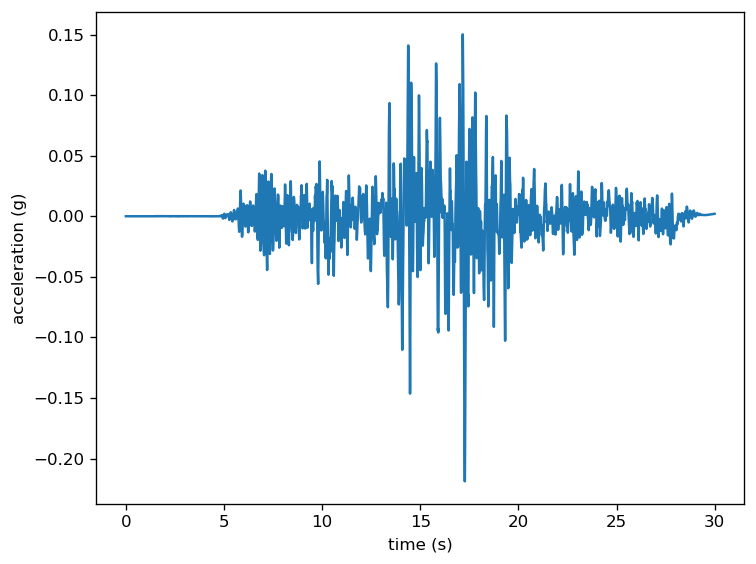

In [8]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel='time (s)', ylabel='acceleration (g)')
fig.tight_layout()

### ΕΙΣΑΓΩΓΗ ΕΔΑΦΙΚΩΝ ΣΤΡΩΣΕΩΝ 

In [9]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.KishidaSoilType(unit_wt=16.0, stress_vert=40, organic_content=5, lab_consol_ratio=1),
            5,
            140,
        ),
        pystrata.site.Layer(
            pystrata.site.KishidaSoilType(unit_wt=18.0, stress_vert=215, organic_content=2, lab_consol_ratio=1),
            15,
            250,
        ),
        pystrata.site.Layer(
            pystrata.site.KishidaSoilType(unit_wt=20.0, stress_vert=650, organic_content=0, lab_consol_ratio=1),
            30,
            450,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 23.0, None, 0.02), 0, 1200),
    ]
).auto_discretize()

### ΓΡΑΦΗΜΑ ΒΑΘΟΥΣ-ΤΑΧΥΤΗΤΑΣ ΔΙΑΤΜΗΤΙΚΩΝ ΚΥΜΑΤΩΝ

<AxesSubplot:xlabel='Initial $V_s$ (m/s)', ylabel='Depth (m)'>

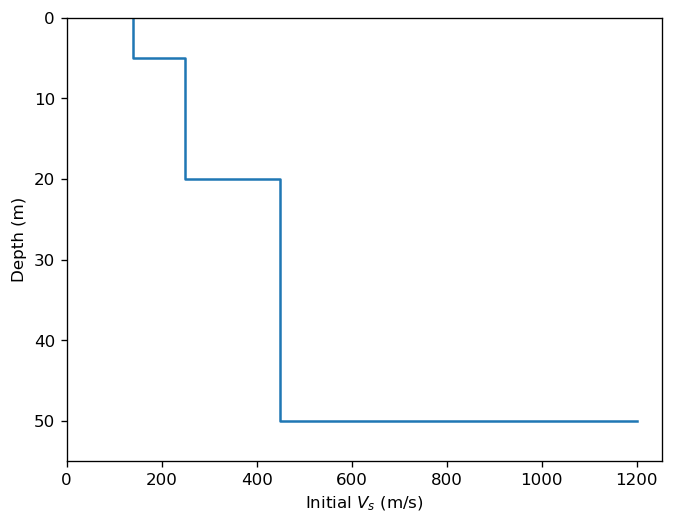

In [10]:
profile.plot("initial_shear_vel")

### ΟΡΙΣΜΟΣ ΜΕΘΟΔΟΥ ΑΝΑΛΥΣΗΣ

In [11]:
calcs = [
    pystrata.propagation.EquivalentLinearCalculator()
]

### ΟΡΙΣΜΟΣ ΕΞΑΓΟΜΕΝΩΝ 

In [12]:
freqs = np.logspace(-1, 2, num=113)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ), 
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
       
    ]
)

In [13]:
motion = pystrata.motion.TimeSeriesMotion('Kocaeli.txt', description='', time_step=ts.time_step, accels=ts.accels)

### ΥΠΟΛΟΓΙΣΜΟΙ ΜΕΘΟΔΟΥ ΑΝΑΛΥΣΗΣ 

In [14]:
for c in calcs:
    c(motion, profile, profile.location("outcrop", index=-1))
    outputs(c, f"{c.strain_limit:0.2f}")

### ΕΚΤΥΠΩΣΗ ΓΡΑΦΗΜΑΤΩΝ

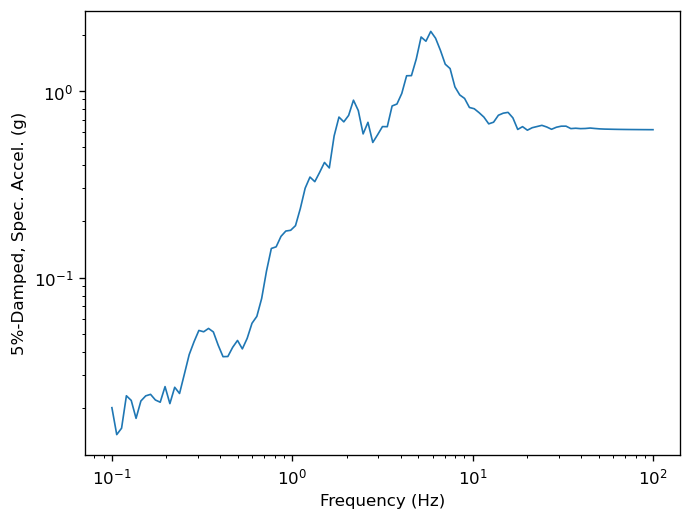

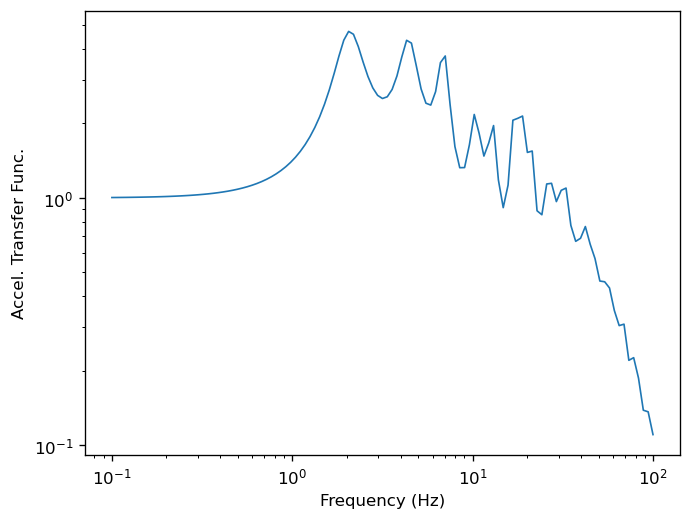

In [15]:
for o in outputs[:2]:
    ax = o.plot(style="indiv")
    

In [16]:
df = outputs[0].to_dataframe()
df

,0.05
0.100000,0.020076
0.106362,0.014399
0.113128,0.015580
0.120325,0.023249
0.127980,0.021956
...,...
78.137074,0.620748
83.108005,0.620462
88.395177,0.620206
94.018709,0.619983


In [17]:
df = outputs[1].to_dataframe()
df

,0.05
0.100000,1.002864
0.106362,1.003297
0.113128,1.003756
0.120325,1.004245
0.127980,1.004861
...,...
78.137074,0.225651
83.108005,0.186513
88.395177,0.138317
94.018709,0.136266


### ΕΞΑΓΩΓΗ ΔΕΔΟΜΕΝΩΝ ΣΕ ΑΡΧΕΙΟ .xls

In [18]:
df = outputs[0].to_dataframe()
df.to_excel('KISHIDA KOCAELI.xlsx', index=True)